# Women in STEM workforce: Predict income and field of work

### What is in this notebook?

We have looked at the STEM gender pay gap over the years in the EDA notebook of the same folder. Even though women has taking up bigger part among the jobs between the years of 2003 and 2013, women's salaries remain 40% lower than men's in average! The analysis also shows how the gender gap compare to one another in the various fields in STEM areas. 

In this notebook, I will explore using machine learning models to predict the income and principal job field given other aspects of the data. It would answer the question of what kind of pay and what types of job would a STEMer expect to receive in the work force.

## Importing Modules and Data

In [1]:
# import important stuff
import numpy as np
import pandas as pd

In [2]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
# import stats modules
from scipy.stats import ttest_ind, chi2_contingency

In [4]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [5]:
# import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df3 = pd.read_csv('./../data/highered_00008.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )

# merge the data frames containing different features
dfm = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])
df = dfm.merge(df3, on=['PERSONID', 'YEAR', 'SURID'])

### Explanation of the survey 

https://highered.ipums.org/highered/survey_designs.shtml

This notebook will only consider the entries with a job. So the labor force status was chosen in the next cell and some irrelevent or heavily missing data columns were removed.  

In [6]:
#drop columns with irrelevant or many missing data
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
df_employed_l = df_employed_small.dropna()

In [7]:
df_employed_l.columns

Index(['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'NOCPR', 'NOCPRMG',
       'SALARY', 'JOBSATIS', 'EMSEC', 'EMSIZE', 'GOVSUP', 'WAPRSM', 'ACTCAP',
       'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WKTRNI',
       'WAPRI', 'WASEC', 'WASCSM'],
      dtype='object')

## Correlations Overviews


As a quick check, I take a look at the Pearson correlation coefficient of Salary column and the rest of columns. 

In [8]:
print('Top correlated:')
print(df_employed_l.corr()['SALARY'].sort_values(ascending=False).head(6))
print('Top reverse correlated:')
print(df_employed_l.corr()['SALARY'].sort_values(ascending=True).head(5))

Top correlated:
SALARY     1.000000
HRSWKGR    0.403946
DGRDG      0.263496
GENDER     0.257586
EMSEC      0.215927
SURID      0.193761
Name: SALARY, dtype: float64
Top reverse correlated:
ACTTCH   -0.183005
WAPRI    -0.172204
HD03Y5   -0.167808
BIRYR    -0.162161
WASCSM   -0.141206
Name: SALARY, dtype: float64


This gets interesting already! We see the top five positively correlated features include full time job status (HRSWKGR: hours worked per week), degree (DGRDG and SURID), gender, and employer sector (EMSEC). 

I would like to point out gender apparently made it to the top three correlated feature deciding a salary: being a man is likely to receive a higher pay than woman. This is another indicator of the pay disprancy between genders. Another insight from this is how the employer sector is playing an important role. The expected pay is lowest if working in a school system, higher if working for the govenment, and highest if working for business and industry.

Among the top negatively correlated columns, the first place goes to teaching as prime job activity. Other columns also more or less has teaching in its reason for making the list (expect for birth year). This resonates with the discovery from the positively correlated employer sector. This gives a supporting evidence of how teachers or people who teach are given lower compensation among jobs, for the ongoing teacher strike across the country. 

## Data Preparation for Salary Prediction

### Target column preparation

Here I change salary from a numeric column to a catagorical column. Due to privacy reason, the survey on scientists and engineers provided by Higher Education do not contain location data. As common knowledge tells us, the location could be a large factor in deciding how much a person is getting paid. The cost of living of San Francisco is more than two times that of Omaha, as an example. It is only fair that people in high cost of living areas get better paid than people in low cost of living places. Since this crucial piece of information is missing, it adds a lot of uncertainty into the prediction of the salary. 

To make the task practical, I am going to predict the salary level (low or high), instead of the exact number. 

I have also done some work that looks into the prediction of numeric salary using several regression models. It gave limited the accuracy scores due to above reasons. Please find the details in regression notebook in the same folder if interested.

In [9]:
# define a function change the salary column to a salary level column
def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<60000:
            new_s[i] = 0
        else:
            new_s[i] = 1
    return new_s

# define a dataframe only contains salary that is larger than 0 (eliminate the entry fault)
df_employed_clf =[]
df_employed_clf = df_employed_l[(df_employed_l['SALARY']>0)]



new_salary = salary_bracket(df_employed_clf['SALARY'])

We define a new dataframe that is similar to the previous one except for it contains only the salary level column. Note the birth year column (BIRYR) is a dependent variable on YEAR and AGE. This column is dropped blow. Some major groups columns is also dependent on the other columns in the survey data, they will be dropped as well. 

In the meantime, we choose the part of the data considering only full time jobs (hours per week >=36).

In [10]:
df_employed_nod = []
df_employed_nod = df_employed_clf.assign(salary_d=pd.Series(new_salary).values)
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)
df_employed_nod=df_employed_nod.drop(['BIRYR','NBAMEMG','NDGMEMG','NOCPRMG'], axis=1)
df_employed_nod=df_employed_nod[(df_employed_nod['HRSWKGR']==3) | (df_employed_nod['HRSWKGR']==4)]

A quick look at the distribution of the pay between men and women. Much more men were paid above 60k income than women while the count of women and men paid below 60k remain similar. This also gives that more entries report higher than 60k salary than below 60k. 

<function matplotlib.pyplot.tight_layout>

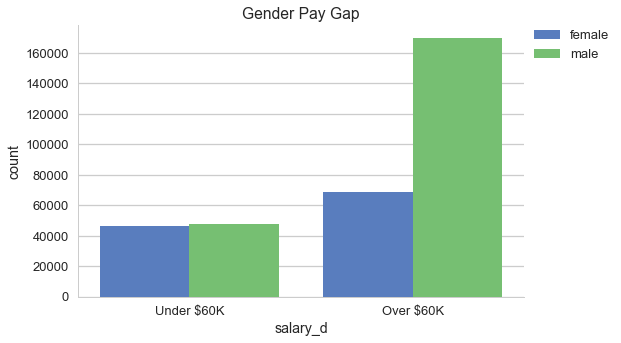

In [11]:
#bar plot of gender and salary 
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
sns.countplot(data=df_employed_nod, x = 'salary_d', hue= 'GENDER', palette="muted", ax=ax)
sns.despine()
plt.title('Gender Pay Gap')
ax.set_xticklabels(['Under $60K', 'Over $60K'])
lgd=ax.legend(['female', 'male'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout
#plt.savefig('./../results/gendersalary.png',bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 150)


It is obvious from the plot above that there are much more men making more than $60k a year compared than women. We have learned from the EDA notebook that the gender pay gap exists and did not improve over the years from 2003 to 2013. This is another quick look at it. Please find the EDA notebook if you are looking for more details on this matter. 

### Numeric Columns

Define the numeric columns and assign the rest of the feature columns to categoric columns. 

In [12]:
numeric = ['AGE']
feature_df = df_employed_nod.drop(['salary_d'],axis=1)
categoric = feature_df.columns.difference(numeric)

I look into the numeric column and check its distribution. The age profile in this data set is not really normal distribution. It is caused by the nature human behavior, people usually do not start working after college, some people tend to stay in the work force longer than the other. So we see a jump at 25 and a long tail after 60. The good news is that our survey data is large (391,000 entries), the null hypothesis will work here according to the central limit theorem (CLT). 

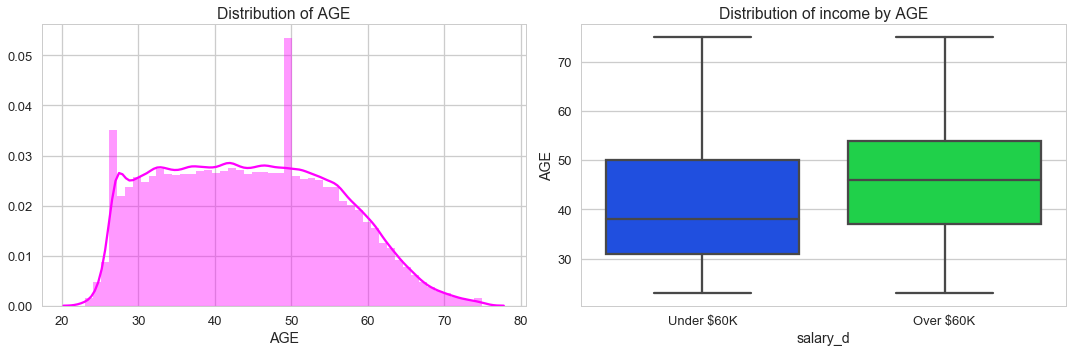

P-values from t-tests


,Attribute,P_value
0,AGE,0.0


In [13]:
p_vals = pd.DataFrame(columns=['Attribute', 'P_value'])

for col in numeric:
   
    # Plotting distributions of each column
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(df_employed_nod[col], color='magenta')
    plt.title('Distribution of {}'.format(col))

    # Plotting distributions of each column by income level
    plt.subplot(122)
    g = sns.boxplot(x='salary_d', y=col, data=df_employed_nod, palette='bright')
    g.set_xticklabels(['Under $60K', 'Over $60K'])
    plt.title('Distribution of income by {}'.format(col))
    plt.tight_layout()
    plt.show()

    # Calculating pvalues from t-test
    t_val, p_val = ttest_ind(df_employed_nod[df_employed_nod['salary_d']==0][col],
                                df_employed_nod[df_employed_nod['salary_d']==1][col])
    p_vals = p_vals.append({'Attribute':col, 'P_value':float(p_val)}, ignore_index=True)
    

# Printing p-values of t-tests, sorted by p-values
print('P-values from t-tests')
p_vals.sort_values('P_value')


The p_value for the numeric columns are practically zero, which means age is statistically significant to determine the salary level of an individual. We will keep it as it is. 

### Categorical columns

Next we prepare the categorical feature columns for classification. We are going to convert these categorical variable into dummy/indicator variables, calling the get_dummies function by pandas (thank you Pandas!). Note the drop_first parameter was set to true to avoid collinearity.

In [14]:
feature_df = df_employed_nod.drop(['salary_d'],axis=1)
categoric = feature_df.columns.difference(numeric)
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

,AGE,salary_d,ACTCAP_1.0,ACTDED_1.0,ACTMGT_1.0,ACTRD_1.0,ACTRDT_1.0,ACTRES_1.0,ACTTCH_1.0,BTHUS_1,...,WASEC_14.0,WASEC_15.0,WKSWKGR_2.0,WKSWKGR_3.0,WKSWKGR_4.0,WKTRNI_1.0,YEAR_2006,YEAR_2008,YEAR_2010,YEAR_2013
0,47,0.0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,66,1.0,0,1,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,60,1.0,1,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
3,30,1.0,0,1,0,1,1,1,0,1,...,0,0,0,0,1,1,0,0,0,0
5,51,1.0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0


Next, we go through all the dummied categorical variables and do the chi-squared test with the salary level column. The purpose is to filter out attributes that statistically insignificant. This will simplify our model.

In [15]:
p_vals_cate = pd.DataFrame(columns=['Attribute', 'P_value'])
categoric = df_employed_nod_sig.columns.difference(['AGE','salary_d'])
p_large = []

for col in categoric:
    # Creating cross tabulated data for Chi-square test
    counttable = pd.crosstab(df_employed_nod_sig[col], df_employed_nod_sig['salary_d'])
    chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
    p_vals_cate = p_vals_cate.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    if p>0.01:
         p_large.append(col)
    
# Printing p-values of Chi-squared tests, sorted by p-values
print('P-values from Chi-Squared Contingency Tests')
print(p_vals_cate.sort_values('P_value', ascending=False).head(10))

print('info of df before deleting insignificant attributes:')
print(df_employed_nod_sig.info())

df_employed_nod_sig_2  = df_employed_nod_sig.drop(p_large, axis=1)

print('info of df after:')
print(df_employed_nod_sig_2.info())

P-values from Chi-Squared Contingency Tests
          Attribute   P_value
115      SAMPLE_801  0.851496
25      HD03Y5_1956  0.427363
76    NDGMED_611995  0.284468
87   NOCPR_393995.0  0.108034
89   NOCPR_432360.0  0.104620
145      WASEC_13.0  0.071465
137      WASCSM_2.0  0.071465
153       WASEC_7.0  0.064534
26      HD03Y5_1961  0.060264
3        ACTRDT_1.0  0.039083
info of df before deleting insignificant attributes:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333044 entries, 0 to 478746
Columns: 166 entries, AGE to YEAR_2013
dtypes: category(1), int64(1), uint8(164)
memory usage: 67.5 MB
None
info of df after:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333044 entries, 0 to 478746
Columns: 152 entries, AGE to YEAR_2013
dtypes: category(1), int64(1), uint8(150)
memory usage: 63.0 MB
None


As we can see above, fourteen columns are deleted because their Chi-Squared cntingency tests p-value is larger than defined significance level (0.01). These statistically insignificant features include certain part of the survey, some secondary job activities, certain some majors and etc..

### Train Test Split

Next we define the target coloumn and the feature columns, using the results from the previous preparation. Scikit-learn's train_test_split makes it easy to separate the data into training and test data. 

Before we proceed to the next step, recall that the distribution of the salary level: there are more entries with higher than 60k salary level. The inbalance will cause under sampling. To avoid this, use the RandomUnderSampler function to ensure we are choosing the same amount of entries from both target classes.  

In [16]:
df_employed_nod_sig_3 = df_employed_nod_sig_2#.sample(frac=0.1, random_state=42)

# Identify variables
X = df_employed_nod_sig_3.drop('salary_d', axis=1)
y = df_employed_nod_sig_3.salary_d

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent Under $60,000: {:.1f}%'.format(
    len(y_train[y_train == 0])/len(y_train)*100))
print('Resampled Training Set Percent Under $60,000: {}%'.format(
    len(y_rus[y_rus == 0])/len(y_rus)*100))

Raw Training Set Percent Under $60,000: 28.7%
Resampled Training Set Percent Under $60,000: 50.0%


## Classification

With the data prepared, we will proceed to test with several classification models. I will find the accuracy score using logistic regression, random forest classifier, KNN, and AdaBoost classifier. For each model, the cross validated grid search will be called find the best parameters. Then the found parameters are fed back into the model for prediction of the test data. 

### Logistic regression:

Logistic regression parameter optimization:

In [17]:
# Initiate list to store the training and testing scores for classification models
score_train = []
score_test = []

In [18]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

Best Score: 0.78095902354
Best Parameters: {'C': 10, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


Logistic regression classification:

In [19]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                            scores_LR_test.std()*2))

score_train.append(scores_LR_train.mean())
score_test.append(scores_LR_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.78174(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.81533(+/- 0.00)
Confusion matrix on the test data:
[[ 51466  14097]
 [ 37430 130138]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.58      0.78      0.67     65563
        1.0       0.90      0.78      0.83    167568

avg / total       0.81      0.78      0.79    233131



By checking the logistic regression coefficient, we can take a glance at the features that contribute most to the classification of our target.  

In [20]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher income levels')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on higher income levels


,Attribute,Coef,Odds_Ratios
21,EMSIZE_8.0,2.049162,7.761397
11,DGRDG_4,2.011932,7.477754
20,EMSIZE_7.0,1.726152,5.618988
10,DGRDG_3,1.691709,5.428751
19,EMSIZE_6.0,1.556426,4.741845


The result is insightful! We found:

1. professional or doctorate degrees both play a important positive role in being classified into the higher salary level. 

2. The size of the employer is another important attribute: Chances are you will get a better pay working for a large coorporate employer (large than 5000 employees). 

3. The last feature among the top five positive impact is the principal job field. Being the science and engineering manager is advantageous to receiving a higher salary, which is reasonable and inspiring.

### Random Forest Classifier

Random forest classifier parameter optimization:

In [21]:
rf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100, 300]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.78385353095
Best Parameters: {'max_depth': 100, 'max_features': 10, 'n_estimators': 75}


Random forest classification:

In [22]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

score_train.append(scores_rf_train.mean())
score_test.append(scores_rf_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.78405(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.82578(+/- 0.00)
Confusion matrix on the test data:
[[ 51336  14227]
 [ 35302 132266]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.59      0.78      0.67     65563
        1.0       0.90      0.79      0.84    167568

avg / total       0.82      0.79      0.80    233131



### KNN

KNN parameter optimization:

In [23]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": [5, 10, 15],
              "leaf_size": [10, 30, 50],
              "weights": ['uniform', 'distance']
              }


grid_knn = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_knn.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_knn.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_knn.best_params_
print('Best Parameters:', best_params)

Best Score: 0.744864864865
Best Parameters: {'leaf_size': 50, 'n_neighbors': 15, 'weights': 'distance'}


KNN classification:

In [24]:
#initiate a instance for classifier
knn = KNeighborsClassifier(**best_params)

# Fit the classifier to the training data
knn.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

scores_knn_train = cross_val_score(knn, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_knn_train.mean(), 
                                                                                 scores_knn_train.std()*2))
scores_knn_test = cross_val_score(knn, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_knn_test.mean(), 
                                                                                 scores_knn_test.std()*2))

score_train.append(scores_knn_train.mean())
score_test.append(scores_knn_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.74486(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.79986(+/- 0.00)
Confusion matrix on the test data:
[[ 46543  19020]
 [ 35723 131845]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.57      0.71      0.63     65563
        1.0       0.87      0.79      0.83    167568

avg / total       0.79      0.77      0.77    233131



### Adaboost

AdaBoost classifier parameter optimization:

In [25]:

param_grid = {
              "n_estimators": [10, 100, 200]
             }


ABC = AdaBoostClassifier()

# run grid search
grid_ab = GridSearchCV(ABC, param_grid=param_grid)

grid_ab.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_ab.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_ab.best_params_
print('Best Parameters:', best_params)

Best Score: 0.778308631212
Best Parameters: {'n_estimators': 200}


AdaBoost classification:

In [26]:
#initiate a instance for classifier

ab = AdaBoostClassifier(**best_params)

# Fit the classifier to the training data
ab.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = ab.predict(X_test)

scores_ab_train = cross_val_score(ab, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_ab_train.mean(), 
                                                                                 scores_ab_train.std()*2))
scores_ab_test = cross_val_score(ab, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_ab_test.mean(), 
                                                                                 scores_ab_test.std()*2))

score_train.append(scores_ab_train.mean())
score_test.append(scores_ab_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.77932(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.81329(+/- 0.00)
Confusion matrix on the test data:
[[ 51145  14418]
 [ 37346 130222]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.58      0.78      0.66     65563
        1.0       0.90      0.78      0.83    167568

avg / total       0.81      0.78      0.79    233131



### Model Comparison 

In [27]:
models = ['Logistic Regression', 'Random Forest Classifier', 'KNN', 'AdaBoost']
model_comp = pd.DataFrame(
    {'models': models,
     'Accuracy score on train': score_train
     'Accuracy score on test': score_test
    })
print(model_comp)

SyntaxError: invalid syntax (<ipython-input-27-e51dfd6c5ef9>, line 5)

In [ ]:
## prepare ROC curve plot
y_pred_prob_lg = clf.predict_proba(X_test)[:,1]
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_prob_knn = knn.predict_proba(X_test)[:,1]
y_pred_prob_ab = ab.predict_proba(X_test)[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob_lg)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_prob_knn)
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_test, y_pred_prob_ab)


# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lg, tpr_lg, 'red', label='Logistic regression')
plt.plot(fpr_rf, tpr_rf, 'blue', label='Random Forest Classifier')
plt.plot(fpr_knn, tpr_knn, 'green', label='KNN')
plt.plot(fpr_ab, tpr_ab, 'yellow', label='Adaboost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

### Predict the salary level among women employees in 2013:

It is now a good time to run the model with the latest data for women employees. Nevertheless, the focus of this project is women in STEM workforce and we can get the most related insight using the most recent data. So next, we choose the women and year 2013 in the survey data and use logistic regression to predict the salary level. 

In [ ]:
df_employed_nod_sig_3 = df_employed_nod_sig_2
# Identify variables
X = df_employed_nod_sig_3[(df_employed_nod_sig_3['GENDER_2']==0)&(df_employed_nod_sig_3['YEAR_2013']==1)].drop('salary_d', axis=1)
y = df_employed_nod_sig_3[df_employed_nod_sig_3['GENDER_2']==0&(df_employed_nod_sig_3['YEAR_2013']==1)].salary_d

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Raw Training Set Percent Under $60,000: {:.1f}%'.format(
    len(y_train[y_train == 0])/len(y_train)*100))
print('Resampled Training Set Percent Under $60,000: {}%'.format(
    len(y_rus[y_rus == 0])/len(y_rus)*100))

In [ ]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

In [ ]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

## Predict the Principal Job Field

Suppose you are a college student, what would you expect when you go to the workforce? Are you going to work on major related fields? Here we are going to answer this question by using machine learning models on the pre-employment portion of the data. 

### Data preparation

In [ ]:
# all the column names in the data frame
df_employed_clf.columns

Here we are planning to predict the field of work for an individual looking for a job, a soon-to-be college graduate for example. This indicates that we don't have any information about the jobs for that person. 

In [ ]:
# Use only columns that are pre-employment. 
# Choose the target column 'NOCPRMG'

df_employed_nod = df_employed_clf[['YEAR', 'SAMPLE', 'SURID', 'AGE', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'NOCPRMG']]


# numeric columns
numeric = ['AGE']
# categoric columns
categoric = df_employed_nod.drop(['NOCPRMG'],axis=1).columns.difference(numeric)

In [ ]:
# change categorical features to dummied columns
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

Take NOCPRMG = 2 as a first look at the problem. The target column indicates whether the principal job field of the individual is biological, agricultural and other life sciences. 

In [ ]:
# define a function to find for a certain type job field only. 
# NOCPRMG = 1, Computer and mathematical scientists
# NOCPRMG = 2, Biological, agricultural and other life scientists
# NOCPRMG = 3, Physical and related scientists
# NOCPRMG = 4, Social and related scientists
# NOCPRMG = 5, Engineers
# NOCPRMG = 6, Science and engineering related occupations
# NOCPRMG = 7, Non-science and engineering occupations

def job_fd(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==2:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rd = job_fd(df_employed_nod_sig['NOCPRMG'])

In [ ]:
df_employed_nod_sig_3 = df_employed_nod_sig#.sample(frac=1, random_state=42)
# Identify variables
X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
y = rd

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

### Logistic regression  

In [ ]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

In [ ]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_rus_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_rus_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_rus_test, y_pred))

Very well predicted! We see there is a 0.86 accuracy score using logistic regression deciding whether an individual is going into the job field of biology and life sciences. 

In [ ]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on job field of biological, agricultural and other life sciences: ')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)

Logistic regression also conveniently tells us the features with most impact on being in the job field: related field of major of the highest degree and the doctorate degree. It seems that students majored in life science with a high level degree is most likely to stay in the same topic when going into the workforce. 

### Job fields comparison

Last, we run the same classification on all the job fields and compare the results. It could give us some insight in what fields are most likely to have predictable employee sources. This question is similar to, what fields of majors are more likely to stay in relevent field when entering the workforce? I choose random forest classification to do this job because it gave the best result in the previous salary level classification. Random forest works well with the size and number of features of this survey data set. 

In [ ]:
# build a list contains the name of the work field. 
score_field_dic = ['Computer and mathematical scientists', 'Biological, agricultural and other life scientists',
              'Physical and related scientists', 'Social and related scientists', 
              'Engineers', 'Science and engineering related occupations',
               'Non-science and engineering occupations']

In [ ]:
# define a function to binarize the target column

def job_fd(ls, n):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==n:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rus = RandomUnderSampler(random_state=41)
train_score=[]
test_score=[]

for i in range(7):
    
    rd = job_fd(df_employed_nod_sig['NOCPRMG'], i+1)
    
    # Identify variables
    X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
    y = rd

    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)

    X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
    X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

    clf = RandomForestClassifier()
    
    param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100]
              }

    grid_rf = GridSearchCV(clf, param_grid=param_grid, cv=5)
    grid_rf.fit(X_rus, y_rus)

    best_params = grid_rf.best_params_

    #initiate a instance for classifier
    rf = RandomForestClassifier(**best_params)

    # Fit the classifier to the training data
    rf.fit(X_rus, y_rus)

    # Predict the labels of the test data: y_pred
    y_pred = rf.predict(X_rus_test)

    scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
    train_score.append(scores_rf_train.mean())
    
    scores_rf_test = cross_val_score(rf, X_rus_test, y_rus_test, cv=5)
    test_score.append(scores_rf_test.mean())
  

In [ ]:
score_df = pd.DataFrame(
    {'Field of Work': score_field_dic,
     'Accuracy score on train': train_score,
     'Accuracy score on test': test_score
    })

score_df.sort_values('Accuracy score on test', ascending=False)

Wow, some insights to discover here:
   1. The random forest classification model does a good job! It predicts the fields of work with accuracy score ranging from 0.72 to 0.91.
   2. Social scientists, physical scientists and engineers are top 3 most predictable field of work in this survey. From the logistic regression coefficient results from the biogical and life scientists field, we could say the mojor field of the highest degree is the most important deciding factor in going into the related job fields. It looks like these top three fields of work have the most predictable human resources. Students majoring in these fields are more likely to enter related workforce. 
   3. Non-science and engineering occupations are least accurately predicted. My thought on this people majoring STEM could go to non STEM job fields for many reasons: change of interest, financial pressure, and career choices, to name a few. The occurance of these could be more random and less predictable than the rest of the job fields. It causes a lower accuracy score. 
    

## Summary

In this notebook, I explored several classification models on the higher education SESTAT survey data, the leading surveys for studying the science and engineering (STEM) workforce. 

I prepared the target, numeric, and catagorical columns for the machine learning models. Statistical functions were used for feature selections. Then four classification models were picked to fit, cross validate and predict the salary level of the entries. I used accuracy scores and ROC curves to compare these methonds. It seems random forest classifier performed best. With the vital geographic location data missing (for privacy reasons), we still got accuracy scores as high as 0.82. 

Next, the question of job field was answered. Which job field do you expect when you go to the workforce? The logistic regression coefficients help to understand the field of major is an important factor in anaswering the question. Each job field appeared was predicted with the pre-employment portion of the data. The classification models does a great job predicting the job field in general. The results find some fields are more accurately predicted than others. 